# Python Programming for Scientists - Day 5

In the fifth (and last!) day we will consider performance, i.e. "how to make my code faster"!

* `multiprocessing`
* `threading`
* `numba` - "just in time" compilation of python code
* `pybind11` - using external c/c++/fortran code

# [0] Parallel Programming

One way to make a given task execute faster is to use **parallel programming**, i.e. having more than one worker working on the task at once, reducing the overall time to completion.

There are two important concepts: **processes vs threads**:
* If you start a program on a computer, its running instance could be called a process.
* A given process can start one, or many, threads.
* Both processes and threads can be thought of as workers which execute a series of commands (e.g. a block of python code).

The main difference is:
* Threads (of the same process) run in a shared memory space, i.e. they can easily share variables and memory. Threads are lightweight (created very fast, low memory overhead).
* Processes run in separate memory spaces: they cannot share variables or memory, unless they explicitly "communicate" (i.e. send and receive) information between themselves. Processes are heavy (slow to start, memory overhead).

You can either use multiple processes, or multiple threads (or both!) to make a program parallel.

By definition all threads (of a process) run together on a single computer. On the other hand, multiple processes can  all run on the same system, or they can be spread across multiple computers.

This leads to the three main models for parallel computing:

* if multiple threads or processes run on the same computer, they can use **shared-memory parallelism**.
* if multiple processes are spread across different computers, this is **distributed-memory parallelism** or **message passing**, in which case communication must occur across a network.
* if the problem is **embarrassingly parallel** it can be trivially split into a number of sub-problems, each being fully independent, and the final result can be assembled after.

We will mostly look at the first case (one computer).

If you want to write a program that needs distributed-memory parallelism (i.e. high-performance computing, analysis of datasets >100s GB which cannot be otherwise split), the low-level package to learn is [mpi4py](https://mpi4py.readthedocs.io/en/stable/). A high-level, very modern option is [dask](https://dask.org/).

# [1] Multiprocessing

A straightforward way to speed up a computation in Python is to have multiple Python processes working together. In this case we use the built-in `multiprocessing` library. This approach is good if:
* there is lots of computation to do, and not much data

In [1]:
import multiprocessing as mp

Imagine we have a function which is very expensive to run:

In [ ]:
def f(x):
    return x*x

If we want to run it for a list of inputs values, and obtain the outputs, we can just do a loop:

In [ ]:
for i in [1,2,3]:
    print(f(i))

The three calls to `f()` run **in serial** (one after another). We can instead run them **in parallel**:

In [ ]:
with mp.Pool() as p:
    args = [1,2,3]
    print(p.map(f, args))

Note: We use the `with` syntax, just like opening a file, to let Python automatically clean up all the internal aspects of `Pool` when we are done with it.

The `Pool.map` function is a helper function which:
* (i) starts a number of independent "child" Python processes
* (ii) distributes ("maps") the set of arguments between these processes
* (iii) runs the function `f` with the argument(s) which each process is responsible for
* (iv) collects the results by sending them back to the "parent" process
* (v) shuts down all the child processes

Note: Initializing `mp.Pool()` will use all the available CPU cores on the current machine (1 process per core). Instead, `mp.Pool(4)` will start only 4 processes, so these will occupy only 4 cores.

> If you are sharing a system (non-exclusive), you will want to avoid using all the CPU cores.
>
> If you are on a system with only 1 CPU core, there is no point to multiprocessing.

Note: the `Pool.starmap` function is similar, except that each element of `args` is extended to also be a list, which is then unpacked and passed to `f` as a list of arguments.

> For example, an iterable of `args = [(1,2), (3, 4)]` results in `[func(1,2), func(3,4)]`.

This is a convenient helper which abstracts away much of the complexity. For instance, what if we want to run `f()` on 10 different arguments, but only have 4 cores (and so 4 processes)? This is automatically handled:

In [ ]:
with mp.Pool(4) as p:
    args = np.arange(10)
    print(p.map(f, args))

One important note to keep in mind: data passed between the processes (the arguments, and the return) is pickled ("serialized", using the same `pickle` library we saw earlier to save/load an arbitrary Python object). This is **only ok for small data sizes**, but extremely slow/problematic for large data (e.g. > GB).

Is it actually faster? Let's make a more expensive function, then benchmark it.

In [21]:
args = [1,2,3]

def f(x):
    j = 0
    for i in range(10000000):
        j += x*x
    return j

## Profiling timing, and memory usage

In [7]:
import time

start_time = time.time()

for i in args:
    print(f(i))
    
print(f'Took {time.time() - start_time:.2f} seconds.')

10000000
40000000
90000000
Took 2.76 seconds.


In [4]:
start_time = time.time()

with mp.Pool() as p:
    print(p.map(f, args))
    
print(f'Took {time.time() - start_time:.2f} seconds.')

[10000000, 40000000, 90000000]
Took 1.17 seconds.


Ideally, the second case finished in a shorter amount of time. If the "scaling" was perfect, then running `N` processes on `N` cores, the total time to finish the computation should be `N` times lower. In practice, it will never be quite as good.

We can avoid having to do the timing ourselves with a useful helper (in IPython or a notebook):

In [7]:
%%time
with mp.Pool() as p:
    print(p.map(f, args))

[10000000, 40000000, 90000000]
CPU times: user 11.4 ms, sys: 133 ms, total: 145 ms
Wall time: 1.18 s


Similarly, we can use a very convenient "memory profiler" to understand how much memory is used during a given operation. First may need a `pip install --user memory_profiler`.

In [2]:
%load_ext memory_profiler

In [8]:
%%memit
with mp.Pool() as p:
    print(p.map(f, args))

[10000000, 40000000, 90000000]
peak memory: 234.91 MiB, increment: 0.03 MiB


And we can combine the two:

> Note: The double `%%` times the whole cell. If you have a single-line command, you can do e.g. `%time func()`, with just one `%`.

In [9]:
%%time
%%memit
with mp.Pool() as p:
    print(p.map(f, args))

[10000000, 40000000, 90000000]
peak memory: 234.93 MiB, increment: 0.00 MiB
CPU times: user 96.3 ms, sys: 74.6 ms, total: 171 ms
Wall time: 1.28 s


### Exercise

Write a loop to benchmark a function like `f()` above, testing multiprocessing pools with different numbers of processes (e.g. `1, 2, 4, 8`). Plot the time to solution versus number of processes. Plot the "speedup" (relative to `N=1`) versus number of processes.

In [10]:
# your solution here


# [2] Threading

The Python standard library provides `threading`, which provides a clean interface to work with threads.

In [1]:
import threading

Let's use the same function as above, as an example of something which takes a bit of time to run:

In [7]:
args = [1,2,3]

def f_save(x, results, results_index):
    j = 0
    for i in range(10000000):
        j += x*x
        
    results[results_index] = j

Instead of returning the answer, we pass our work function a `results` array, as well as a `results_index` indicating where in that array it should store its result.

Our plan is that: each thread will compute one answer as a number, and all threads will store their results in the same `results` array (in different places).

We can make threads, start them manually, and collect the results:

In [9]:
%%time
threads = []

# allocate an array to store the results
results = np.zeros(len(args), dtype='int64')

# create a list of Thread objects, each set to run f(arg) when it starts, one thread per element of args
for i, arg in enumerate(args):
    t = threading.Thread(target=f_save, args=(arg,results,i))
    threads.append(t)
    
    # spawn this thread, tell it to start, and "detach" it so it can run independently (likely on a different CPU core automatically)
    t.start()
    
# now the threads are all working

# wait for each to finish (re"join" the master thread, i.e. this one)
for thread in threads:
    thread.join()
    
print(results)

[10000000 40000000 90000000]
CPU times: user 2.56 s, sys: 7.97 ms, total: 2.57 s
Wall time: 2.53 s


## Subclassing Thread to store a return value

As an alternative to preparing a separate `results` array (or list) ahead of time, and then filling a specific index with the result from each thread, we can instead create a custom sub-class of `Thread` (using inheritance), which uses an attribute (class variable) to store the return of `f()`, which we can then access after all threads have completed their work:

In [57]:
class MyThread(threading.Thread):
    def __init__(self, target, *args, **kwargs):
        # call the __init__() method of the parent class
        super(MyThread, self).__init__()
        
        # save the target function, any arguments
        self.target = target
        self.args = args
        self.kwargs = kwargs
        
    # when Thread.start() is called it in turn calls run(), which we override, saving the return of target() into an attribute variable
    def run(self):
        self.result = self.target(*self.args, **self.kwargs)
        
    # when join() is called, call the join() method of our parent Thread class, then return our result
    def join(self):
        super(MyThread, self).join()
        return self.result

Now we can use `MyThread` instead of `threading.Thread`, with its added functionality:

In [58]:
threads = []

# create a list of MyThread objects, each set to run f(arg) when it starts, one thread per element of args
for arg in args:
    t = MyThread(f, arg)
    threads.append(t)
    
    # spawn this thread, tell it to start, and "detach" it so it can run independently (likely on a different CPU core automatically)
    t.start()
    
# wait for each to finish (re"join" the master thread, i.e. this one), and capture the return of .join() into a list
results = [t.join() for t in threads]

print(results)

[10000000, 40000000, 90000000]


## Race conditions

Because **threads share memory**, it is very easy to get into trouble. You should **never write the same piece of memory from more than one thread**. You should also **never read a piece of memory from one thread which has been written to by another**.

* When multiple threads are running, they are effectively racing against each other.
* You don't know which will reach a particular code block first, so you don't know if such a "common" memory space has been written by another thread already, or not.
* As a result, the value of that memory space (variable) can be unexpected.
* This leads to **race conditions** (multiple threads interfere with each other) and **deadlock** (due to such interference, a thread may end up waiting forever and never finishing).
* These types of problems do not necessarily happen each time you run the same program, but can happen only occasionally: they are not easily reproducible, and can be **non-deterministic**. Very hard to fix. Better to avoid at all costs.

Let's make a very simple example to understand the problem. We will create a race condition which happens every time, to be clear:

In [41]:
import time

class VisitorCounter():
    def __init__(self):
        self.count = 0

    def update(self, thread_num):
        print('Thread %d, starting update.' % thread_num)

        local_value = self.count
        local_value += 1
        time.sleep(2.0)
        self.count = local_value

        print('Thread %d, finished update.' % thread_num)

This `update()` function emulates what might happen in a database, for example. `value` could be a visitor counter on a website, and each time someone visits, we want to increase the counter by one.

In [42]:
threads = []
counter = VisitorCounter()

# create and start two threads
for i in range(2):
    t = threading.Thread(target=counter.update, args=(i,))
    threads.append(t)
    
    t.start()
    
# wait for both to finish
for thread in threads:
    thread.join()

Thread 0, starting update.
Thread 1, starting update.
Thread 0, finished update.
Thread 1, finished update.


## Exercise

What is the final value of `counter.count`? What happened? Copy the code block from above and change it to run the two threads in serial, one after another. What happens to the final counter value?

In [44]:
# your solution here


## Synchronization between threads (Lock)

Although the example above may seem silly and easy to avoid, such problems actually happen and can be very hard to identify.

There are a number of ways to avoid or solve race conditions. In the [threading documentation](https://docs.python.org/3/library/threading.html) you will find "synchronization primitives" called `Lock`, `RLock` (reentrant lock), `Semaphore`, and so on. These are all parallel programming concepts on how multiple threads can coordinate with each other. As are: `Mutex`, `Events`, `Signals`, `Condition variables`.

We will only look quickly at the simplest, which is a `Lock` (very similar to what a `Mutex`, or "mutual exclusion", is in other languages).

To solve the race condition above, we need to allow only one thread at a time into the read-modify-write "section" of the code. A `Lock` lets us do this:
* a lock is an object which is like a hall pass in school.
* only one thread at a time can have the lock.
* any other thread which wants the lock must wait until its current owner gives it up (i.e. back to the teacher).
* the basic methods are `.acquire()` and `.release()`.

> Note: if one thread gets the lock, but never gives it back, your program will never finish: a deadlock.

Let's update our `VisitorCounter` class from above:

In [49]:
class VisitorCounterWithLock():
    def __init__(self):
        self.count = 0
        self._lock = threading.Lock()

    def update(self, thread_num):
        print('Thread %d starting update.' % thread_num)

        with self._lock:
            # before entering this block, the function must acquire the lock
            print('Thread %d has lock.' % thread_num)
            local_value = self.count
            local_value += 1
            time.sleep(2.0)
            self.count = local_value

        print('Thread %d finished update, releasing lock.' % thread_num)

In [50]:
threads = []
counter = VisitorCounterWithLock()

# create and start two threads
for i in range(2):
    t = threading.Thread(target=counter.update, args=(i,))
    threads.append(t)
    
    t.start()
    
# wait for both to finish
for thread in threads:
    thread.join()

Thread 0 starting update.
Thread 1 starting update.
Thread 1 has lock.
Thread 1 finished update, releasing lock.Thread 0 has lock.

Thread 0 finished update, releasing lock.


## Python's "Global Interpreter Lock": the bane of multithreaded programming.

Before finishing with threading, let's test our performance gain by profiling our slow function `f()` which we have sped up.

### Exercise

Call `f(arg)` for each `arg` in `args` (just use a for loop, like you did in the exercise above). This will run the computation in serial. Time it: what is the total time? How does this compare to our first result (where we used `%%time` above)?

In [59]:
# your solution here


We have achieved absolutely no speedup!

The problem is that, due to the [Global Interpreter Lock](https://docs.python.org/3/glossary.html#term-global-interpreter-lock), **only one thread can execute Python code at once**.

> This is quite a bummer. (Many people would like to change this in Python, but not yet).
>
> So why would you ever use multiple threads?
>
> If a thread started in Python "lowers" out of the Python interpreter, e.g. starts to run pure C or C++ code, then it can release the GIL and circumvent this problem.

# [3] Numba

But, writing C/C++ code is hard. We rarely want to do this. The best solution is the [numba](https://numba.pydata.org/) library.

> Numba translates Python functions to optimized machine code "just-in-time" (JIT), i.e. at the moment you run the code (using the "LLVM" compiler).
>
> Numba-compiled numerical algorithms in Python can approach the speeds of C or FORTRAN (or be faster).
>
> You don't need to change your code, replace the Python interpreter, run a compiler, or even have a C/C++ compiler installed. Just apply the Numba decorator to a Python function, and Numba does the rest.

In [61]:
from numba import jit

First let's look at a simple example, a method of calculating the value of $\pi$ using a Monte Carlo approach.

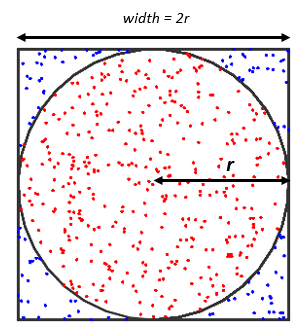

In [64]:
from IPython import display
display.Image("images/day5_mc_pi.png")

The idea is to use the equation for the area of a circle: $A = 2 \pi r^2$ relative to the area of a square $A = r^2$. The ratio between the two is $2 \pi$. If we imagine throwing random darts at a square board, the number which fall within the circle, relative to the total, give us a "Monte Carlo" estimate of this number:

In [77]:
import random

def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

Note: you should **never write a for-loop based code in Python, when you can use numpy instead!** We show this only for demonstration.

In [78]:
%time monte_carlo_pi(10000000)

CPU times: user 4.37 s, sys: 0 ns, total: 4.37 s
Wall time: 4.37 s


3.1417416

## Exercise

Re-write the `monte_carlo_pi()` function above using numpy, and no for loops. Compare the speed. (This has nothing to do with numba, it is just a check that we remember Day 2).

In [86]:
# your solution here


## Using the numba 'jit' decorator

In [112]:
@jit(nopython=True)
def monte_carlo_pi_numba(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [87]:
%time monte_carlo_pi_numba(10000000)

CPU times: user 146 ms, sys: 0 ns, total: 146 ms
Wall time: 145 ms


3.1416084

The first time you run the function, numba compiles it behind the scenes. This can add some time, so for benchmarking, always run it a few times.

> In practice, the time for the function to run will be much, much greater than the compilation time.

Although for this simple algorithm we could use numpy, many more complex algorithms and analyses cannot easily be re-written without loops. **Use numba to keep algorithms with C-like loops.**

> The catch: **numba JIT'ed code must be kept simple**: only numpy arrays, (most) functions, and simple operations. No file I/O! No fancy python: avoid dictionaries, classes, etc. Keep it simple..
>
> See [supported python features](https://numba.readthedocs.io/en/stable/reference/pysupported.html) and [supported numpy features](https://numba.readthedocs.io/en/stable/reference/numpysupported.html).

## Exercise

If `nsamples=1e8` (one billion), what is the peak memory usage of `monte_carlo_pi_numba` (don't code, just think about it)? Peak memory means the largest amount of memory used, at any point in the program. What about `monte_carlo_numpy`? Now, memory profile the actual function (use `%memit`).

In [120]:
# your solution here


## Automatic parallelism with numba

Numba can also automatically run code in parallel on multiple CPU cores. It can also run code automatically on [GPUs](https://numba.readthedocs.io/en/stable/cuda/overview.html) (outside of our scope). Let's take a quick look:

In [89]:
from numba import njit, prange

This is just a shorthand, decorating with `@njit` is the same as with `@jit(nopython=True)`.

You always want to use this "no-python" mode, which means that the code must compile successfully and run outside of python, outside an error is thrown.

If you remove this requirement, then numba will simply run code it cannot compile as normal, but then you will silently have slow code. Better to:
* (i) extract the compute intensive code from your existing Python into a new function,
* (ii) make it accept simple arguments and return simple outputs,
* (iii) make it use only simple python and numpy functionality, an
* (iv) make sure numba can compile it.

> `prange` is like `range`, but "parallel".

In [108]:
@njit(parallel=True)
def prange_test(A):
    s = 0
    # without "parallel=True" in the jit-decorator, the prange statement is equivalent to range
    for i in prange(A.shape[0]):
        s += A[i]
    return s

In [107]:
x = np.linspace(0, 100, 100000000)
%time print(prange_test(x))

5000000000.000001
CPU times: user 248 ms, sys: 1.13 ms, total: 250 ms
Wall time: 24 ms


The "Wall time" is the actual time (on a clock) which has gone by.
The "CPU time" is the amount of work that the computer has done.

For example, if you have 2 cores working for 1 second each, at the same time, the CPU time is 2 seconds.

In this case, the ratio between the two gives us the speed-up, i.e. about the number of cores used.

## Exercise

Write a function `moving_avg(x,n)` which computes the running average (i.e. [simple moving average](https://en.wikipedia.org/wiki/Moving_average)) of a one-dimensional array `x` using a window size `n`. Benchmark it using some big values for `x` and `n`. Accelerate it with numba, and compute the speed-up.

In [122]:
# your solution here


# [4] Calling C or C++ (or fortran) code

We said "writing C/C++ code is hard, we rarely want to do this" - which is true. But:

* sometimes you have no choice (complex algorithm, need advanced C/C++/fortran features)
* sometimes you have existing code (from colleagues)
* sometimes you want to use an existing library (which only exists in C/C++/fortran)

The easiest approach is to use the **pybind11** library. This is a lightweight header-only library that exposes C++ types in Python and vice versa. Its main use is to create **Python bindings (i.e. wrappers) of existing C/C++ code**.

It works like this. First, we would start with a file `example.cpp` with a function we would like to use:

```c++
    int add(int i, int j) {
        return i + j;
    }
```

We would like to be able to call this function from python. The most basic syntax is to change the source code file by adding the following lines:

```c++
    #include <pybind11/pybind11.h>

    int add(int i, int j) {
        return i + j;
    }

    PYBIND11_MODULE(example, m) {
        m.doc() = "pybind11 example"; // optional module docstring

        m.def("add", &add, "A function that adds two numbers");
    }
```

## Exercise

1. Right-click in the file explorer on the right, select "New File". Rename it to `example.cpp`. Open it, and paste the code above.
2. Open a terminal (File -> New -> Terminal), and compile this source file with the command:

`c++ -O3 -Wall -shared -std=c++11 -fPIC $(python3 -m pybind11 --includes) example.cpp -o example.so
`

3. A file `example.so` should have been made - this is a "shared library", i.e. a binary file with functions which are meant to be called from other programs.
4. Try to run `import example` in Python, then get its documentation with `?example`, and finally, try to use the `add` function:

In [4]:
# your solution here


## Numpy arrays with pybind11

You can also pass numpy arrays into your C++ function. (Also possible to create new numpy arrays in the C++ code, but a bit more complicated). Let's update our source code to:

```c++
    #include <pybind11/pybind11.h>
    #include <pybind11/numpy.h>

    namespace py = pybind11;

    int add(int i, int j) {
        return i + j;
    }

    float multiply_vecs_then_sum(py::array_t<float> a, py::array_t<float> b) {
        float sum = 0.0;
        auto buf_a = a.unchecked<1>(); // request direct memory pointer with no checks
        auto buf_b = b.unchecked<1>(); 

        for(auto i = 0; i < a.size(); i++)
            sum += buf_a[i] * buf_b[i];
        return sum;
    }

    PYBIND11_MODULE(example, m) {
        m.doc() = "pybind11 example"; // optional module docstring

        m.def("add", &add, "A function that adds two numbers");
        m.def("my_f", &multiply_vecs_then_sum, "A pretty strange function!");
    }
```

### Exercise

Update the `example.cpp` source file with the code above, re-compile the `.so` library, and re-import (you may need to Kernel -> Restart Kernel). Create two numpy arrays and test our new function.

In [4]:
# your solution here


One glance at the [docs for using numpy with pybind11](https://pybind11.readthedocs.io/en/stable/advanced/pycpp/numpy.html) shows how things get complicated quickly.

But! It's a very powerful technique. You can pass data from python to C/C++ (without making any copies, reading it directly from memory), use advanced algorithms and techniques in C/C++, and return the result. From the point of view of the Python user, it's always just as simple as `import library` and `library.compute()`.

<hr style="border:2px solid #bbb; margin: 30px 0"> </hr>

# Day 5 Practice Problem - Parallelized $\pi$ Calculation

We will approximate $\pi \simeq 3.1415$ using one of the many series expressions:

$$ \pi = \frac{4}{N} \sum_{i=1}^N \frac{1}{1 + \left(\frac{i-0.5}{N}\right)^2} $$

The accuracy increases as $N$ gets larger.

## Task A

Write a function `series_pi(N)` which computes the above approximation to $\pi$. Run it for values of $N$ spanning several orders of magnitude, and compare the result to `np.pi`, as a function of $N$, with a y-log plot.

In [6]:
# your solution here


## Task B

Use the `multiprocessing` module to create a pool of python workers. Each worker should use `series_pi` to compute a subset of the needed terms for the requested $N$, then the results should be combined. Use `map`. Modify the function as needed. Check the performance benefit versus the serial version.

In [7]:
# your solution here


## Task C

Switch to `threading` to solve the same problem. Make the target function for each thread numba-accelerated.

In [8]:
# your solution here


## Task D

What if you wanted to calculate $\pi$ to a certain accuracy (with respect to `np.pi`)? Use a lock to protect a shared variable which stores the current estimated value, and is periodically updated as calculations progress. Once the accuracy reaches a goal (tolerance), the threads should stop working.

In [9]:
# your solution here


<hr style="border:2px solid #bbb; margin: 30px 0"> </hr>

# Day 5 Challenge Problem - Bitcoin Historical Data with Pandas

A very popular and potentially powerful library is `pandas`. This is particularly useful for loading/analyzing/saving tabular data, e.g. large CSV files, especially data with dates, or anything which looks like this:

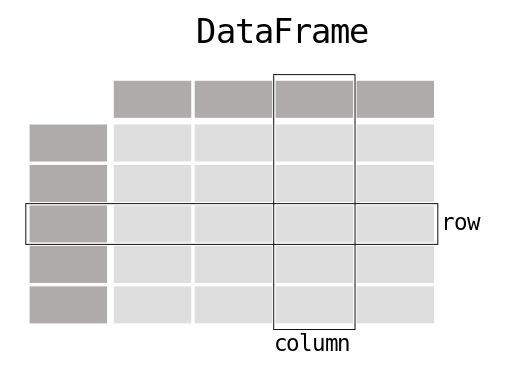

In [1]:
from IPython import display
display.Image("images/day5_pandas.png")

If you're interested, read and work through the [10 minutes to pandas tutorial](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html).

## Task A

Use `pandas` to load [data/day5_btc_eur_daily.txt](data/day5_btc_eur_daily.txt). This file contains historical data on the price of bitcoin, specifically the BTC/EUR exchange rate, on a daily cadence, since the start of 2020.

You can use `pd.read_csv()`, followed by `.describe()` to get an overview of the structure of the loaded data (and make sure pandas interpreted it correctly).

In [7]:
# your solution here

import pandas as pd

## Task B

Use pandas to resample the daily historical data to a weekly cadence. Plot the resulting time series.

In [5]:
# your solution here


## Task C

Use your running mean (SMA) function from before to compute the running average, with a time window of one month. Overplot the result.

In [6]:
# your solution here


## Task D

"Technical indicators" are statistics computed on the price of e.g. a stock, or other financial instrument. One example is the [RSI](https://en.wikipedia.org/wiki/Relative_strength_index). Compute it and include it in your plot as a sub-plot below the main price panel. What is your interpretation?

In [8]:
# your solution here


All done? You're free! You can use the extra time to do the homework exercises if you'd like. I hope you enjoyed the course.

  -- Dylan Nelson